# homework3.1-Fit+cali

## Fit+cali Code

**基本流程：**
- 获得拟合的alpha图谱；
- TSpectrum寻峰；
- map排序挑选对应能量峰位；
- 寻峰结果作为初始值，拟合；
- 由拟合结果与源对应，提取刻度参数；
- 对连续化后能谱刻度；
- 存图；


### 数据结构

```c++
    include：
        Calibasedith.h    //由s4dith.root生成；
        cali.h                 //用户编写fit代码；
    src
        Calibasedith.C    //由s4dith.root生成；
        cali.c                 //用户编写fit代码；
    main.cpp
    makefile
 ```

### main.cpp

```c++
#include <iostream>
#include <sstream>
#include <TFile.h>
#include <TTree.h>
#include <TString.h>
#include "cali.h"
using namespace std;

int main()
{
    TString InputPath, OutputPath, infile, outfile;  
    InputPath = "../";
    OutputPath = "../";
    infile.Form("%ss4dith.root", InputPath.Data());
    //outfile.Form("%shomework%03d.root", OutputPath.Data(), run_number);
    outfile.Form("%ss4cali.root", OutputPath.Data());
    //input
    TFile *ipf = new TFile(infile);
    if(!ipf->IsOpen()) {
        cout<<"Cannot open input file: "<<infile<<endl;
        return -1;
    }
    TTree *ipt = (TTree*)ipf->Get("tree");

    //output
    TFile *opf = new TFile(outfile,"RECREATE");
    TTree *opt = new TTree("tree","pe calibration");
    opf->cd();
    //自己新编写的刻度类;
    //目的是将打开的源root文件中的tree导入到自己编写的类中；继承CaliBasedith.目的为此；
    cali *c = new cali(ipt,opf);
    //自己编写的分析函数，等价MakeClass生产.C文件的Loop函数；此处的tree为输出文件的tree；
    c -> analysis(ipt,opt);


    //
    ipf->Close();
    opf->Close();
    return 1;
    delete c;
}
```

### cali.h
```c++
#ifndef __CALI_H__
#define __CALI_H__

#include <vector>
#include <queue>
#include <map>
#include <functional>
#include <algorithm>
#include <iostream>
#include <sstream>
#include <string>
#include <fstream>

#include <TPad.h>
#include <TFile.h>
#include <TSpectrum.h>
#include <TPolyMarker.h>
#include <TLatex.h>
#include <TH1F.h>
#include <TMultiGraph.h>
#include <TGraph.h>
#include <TLegend.h>
#include <TString.h>
#include <TRandom3.h>
#include <TBranch.h>
#include <TArrayD.h>
#include <TH2.h>
#include <TStyle.h>
#include <TCanvas.h>
#include <TF1.h>
#include <TFitResult.h>
#include <TGraph.h>

#include "CaliBasedith.h"

using namespace std;

class cali:public CaliBasedith
{
public:

	TCanvas * c1;
	TSpectrum * s;		//peak.C寻峰要用
	TH1D ** pefithisto;	//得到拟合用图，最后于拟合曲线一起存图；
	TH1D ** pecalihisto;	//存储刻度后

	TDirectoryFile * dir_pefit;	//存放拟合后的pe图
	TDirectoryFile * dir_pecali;	//存放刻度后的pe图
	TDirectoryFile * dir_pediff;	//存放刻度后的偏差图；

	
	Double_t pecali[48];	//刻度后的pe,以及opf的branch；
	Double_t b[48],k[48];		//拟合alpha峰得到的刻度系数energy = b + k * channes
	Double_t alpha[4] = {5.5658,6.1748,6.6708,8.6931};	//alpha能量
	//存放寻峰以及拟合结果用(三次：寻峰，拟合1，拟合2)，并于后期输出结果，对比检查；
        Double_t means[48][3][4],sigma[48][3][4],count[48][3][4],ch2nd[48][3][4];
         



public:
	//此函数目的就是为了继承CaliBasedith.h中的内容
	//即此处的tree为输入文件的tree，在CaliBasedith.h中更名为fChain
	cali(TTree * ipt,TFile * opf);

	//析构函数
	virtual ~cali();
	virtual void SetOutBranch(TTree * opt);
	virtual void Initialize();
	virtual void MakeAlphaHist(TTree * ipt);
	virtual void peaks(TH1D * h, vector<Double_t> &pe, Double_t thres, Int_t backsub);
	virtual void FitAlphaHist(TH1D * h, Int_t strip);
	virtual void calibration();
	virtual void SavecaliHist();
	virtual void ResultRecord();
	virtual void analysis(TTree * ipt, TTree * opt);
};
#endif
```

### cali.c

```c++
#include "cali.h"
#include "TString.h"

cali::cali(TTree * ipt, TFile * opf):CaliBasedith(ipt)
{
	c1 = new TCanvas();		//随时输出图像，检查数据执行情况；
	s  = new TSpectrum(500);	//pecks用；	
	pefithisto  = new TH1D * [48];
	pecalihisto = new TH1D * [48];
	//给pecali存图赋予名字；
	TString pecaliname;
	for(Int_t i = 0; i < 48; i++)
	{
		pecaliname.Form("pecali[%d]",i);
		pecalihisto[i] = new TH1D(pecaliname.Data(),pecaliname.Data(),1000,0,10);
	}
	dir_pefit  = new TDirectoryFile("dir_pefit","dir_pefit");
	dir_pecali = new TDirectoryFile("dir_pecali","dir_pecali");
	dir_pediff = new TDirectoryFile("dir_pediff","dir_pediff");
	//初始化
	Initialize();

//***	cout<<"实例化完成"<<endl;
}

cali::~cali()
{
	for(Int_t i = 0; i < 48; i++)
	{
		delete pefithisto[i];
		delete pecalihisto[i];
	}
	delete pefithisto;
	delete pecalihisto;
	delete s;
	delete c1;
}

void cali::SetOutBranch(TTree * opt)
{
	//dith后的root继承下来的
	opt->Branch("pedith",&pedith,"pedith[48]/D");
	opt->Branch("redith",&redith,"redith[48]/D");
	//新添加的刻度后的pe
	opt->Branch("pecali",&pecali,"pecali[48]/D");
//***	cout<<"outbranch done"<<endl;
}

void cali::Initialize()
{
	for(Int_t i = 0; i < 48; i++)
	{
		//刻度后pe
		pecali[i] = -1;
		//刻度系数
		     b[i] = 0.;
		     k[i] = 1.;
		//拟合过程存储数据
		for(Int_t j = 0; j < 3; j++)
		{
			for(Int_t k = 0; k < 4; k++)
			{
				means[i][j][k] = -99.;
				sigma[i][j][k] = -99.;
				count[i][j][k] = -99.;
				ch2nd[i][j][k] = -99.;
			}
		}
	}
//***	cout<<"初始化完成"<<endl;
}

void cali::MakeAlphaHist(TTree * ipt)
{
	TString pefitname;
	for(Int_t i = 0; i < 48; i++)
	{
		pefitname.Form("pefithisto[%d]",i);
		ipt->Draw((TString::Format("pedith[%d]>>",i)+pefitname.Data()+"(1000,0,2000)"),"","goff");
		pefithisto[i] = (TH1D*)gROOT->FindObject(pefitname.Data());
//***	h1->Write();
//***	cout<<"创建拟合图像完成"<<endl;
	}
}

void cali::peaks(TH1D * h, vector<Double_t> &pe, Double_t thres, Int_t backsub)
{
	pe.clear();//清空pe
	multimap<Int_t,Double_t> me;//用于排序
	
	TH1D *hb = NULL;//background图；
	if(!s)    s = new TSpectrum(500);

	if(backsub)
	{
    		hb=(TH1D*)s->Background(h,80,"same");//80-本底光滑程度
    		h->Add(h,hb,1,-1);   
	}

	Int_t nfound = s->Search(h,2,"",thres); 

	TPolyMarker *pm=(TPolyMarker *)h->GetListOfFunctions()->FindObject("TPolyMarker");
	pm->SetMarkerStyle(32);
	pm->SetMarkerColor(kGreen);
	pm->SetMarkerSize(0.4);

	Double_t *xpeaks = s->GetPositionX();
	Double_t *ypeaks = s->GetPositionY();

	TString sout;
	for(int j=0;j<nfound;j++) 
	{	
    		stringstream ss;
		ss<<xpeaks[j];
		TString s1 = ss.str();
		TLatex *tex=new TLatex(xpeaks[j],ypeaks[j],s1);
		me.insert(make_pair(int(ypeaks[j]),xpeaks[j]));//map自动按照key大小排序（key，value）
    		tex->SetTextFont(13);
    		tex->SetTextSize(14);
    		tex->SetTextAlign(12);
    		tex->SetTextAngle(90);
    		tex->SetTextColor(kRed);
		h->GetListOfFunctions()->Add(tex);
    		tex->Draw();
	}
	Int_t pnumber = 1;
	for(auto ie=me.rbegin(); ie!=me.rend(); ie++) 
	{	
		//cout<<"Num of Peaks: "<<setw(2)<<pnumber<<" x: "<<setw(7)<<ie->second<<" y: "<<setw(7)<<ie->first<<endl;
		pe.push_back(ie->second);//按照计数由大到小填入
		pnumber++;
	}
  	me.clear();
}


void cali::FitAlphaHist(TH1D * h, Int_t strip)
{
	vector<Double_t> pe;//创建向量pe，存储pecks寻峰的结果；
	peaks(h,pe,0.05,0);//pe按照统计由大到小排列填入了mean；
//***	cout<<"寻峰完成"<<endl;
//***	h1->Write();//for check
	sort(pe.begin(),pe.begin()+6);//对pe中mean由小到大排序；
	Double_t meantmp[4],diff[4];//为了存储mean值构建TGraph，拟合得到刻度系数以及查看残差；
	TGraph * pediffgr;//存放拟合后与源的残差图像，并存入root；
	//存入peak得到的峰位与峰值
	for (Int_t i = 0; i < 4 ; i++)
		{
			means[strip][0][i] = pe[i+2];
			count[strip][0][i] = h->GetBinContent(h->FindBin(pe[i+2]));
//***			cout<<Form("count = %4.f, means = %.2f",count[0][i],means[0][i])<<endl;
		}
		
	//第一次拟合
//***	cout<<"第一次拟合开始"<<endl;
	TF1 * fg1[4];//拟合函数，以便提取拟合参数
	TFitResultPtr fr1;//将拟合结果存入fr1；
	
	for (Int_t i = 0; i < 4 ; i++)
	{
		fg1[i] = new TF1(Form("fg1%d",i),"gaus");
		//设置拟合初始值，count,mean,sigma
		fg1[i]->SetParameters(count[strip][0][i],means[strip][0][i],4);
		//拟合，并限定范围,将拟合结果返回给fr1
		fr1 = h->Fit(fg1[i],"SQ+","",means[strip][0][i]-5,means[strip][0][i]+8);
		//存储拟合结果。以便输出文件；
		count[strip][1][i] = fg1[i]->GetParameter(0);
		means[strip][1][i] = fg1[i]->GetParameter(1);
		sigma[strip][1][i] = fg1[i]->GetParameter(2);
		ch2nd[strip][1][i] = fr1->Chi2()/fr1->Ndf();
//***		cout<<Form("第一次：peaks = %4.f, sigma = %.2f, chi2ndf = %.2f",means[1][i],sigma[1][i],ch2nd[1][i])<<endl;
	}
	//第二次拟合
//***	cout<<"第二次拟合开始"<<endl;
	TF1 * fg2[4];//拟合函数，以便提取拟合参数
	TFitResultPtr fr2;//将拟合结果存入fr2；
	
	for (Int_t i = 0; i < 4 ; i++)
	{
		fg2[i] = new TF1(Form("fg2%d",i),"gaus");
		//设置拟合初始值，count,mean,sigma
		fg2[i]->SetParameters(count[strip][1][i],means[strip][1][i],sigma[strip][1][i]);
		//拟合，并限定范围,将拟合结果返回给fr1
		fr2 = h->Fit(fg2[i],"SQ+","",means[strip][1][i]-5,means[strip][1][i]+8);
		//存储拟合结果。以便输出文件
		count[strip][2][i] = fg2[i]->GetParameter(0);
		means[strip][2][i] = fg2[i]->GetParameter(1);
		sigma[strip][2][i] = fg2[i]->GetParameter(2);
		ch2nd[strip][2][i] = fr2->Chi2()/fr2->Ndf();
		meantmp[i]  = fg2[i]->GetParameter(1);
//***		cout<<Form("第二次拟合结果：peaks = %4.f, sigma = %.2f, chi2ndf = %.2f",means[2][i],sigma[2][i],ch2nd[2][i])<<endl;
	}
	dir_pefit->cd();
	h->Write();//存储带有高斯拟合曲线的pedith；
        //拟合能量-道址，得到刻度系数k，b； 
//***	cout<<"偏差记录"<<endl;
	TGraph * gr = new TGraph(4, meantmp, alpha);//创建拟合图像
//***	gr->Write();
	gr->Fit("pol1","SQ+");//拟合，不显示结果；
	TF1 * f1 = gr->GetFunction("pol1");
	b[strip] = f1->GetParameter(0);
	k[strip] = f1->GetParameter(1);

	for (Int_t i = 0; i < 4 ; i++)
	{
		diff[i] = b[strip] + k[strip] * meantmp[i] - alpha[i];
	}
	
	pediffgr = new TGraph(4, meantmp, diff);
	TString pediffname;
	pediffname.Form("pediff[%d]",strip);
	//pediffgr->SetName(pediffname.Data());
    pediffgr->SetNameTitle(pediffname.Data(), pediffname.Data());
	dir_pediff->cd();
	pediffgr->Write();
}

void cali::calibration()
{
	for(Int_t i = 0;i < 48;i++)
	{
		pecali[i] = b[i]+ k[i]*pedith[i];
		pecalihisto[i]->Fill(pecali[i]);
	}
}

void cali::SavecaliHist()
{
	dir_pecali->cd();
	for(Int_t i = 0; i<48;i++)
	{
		pecalihisto[i]->Write();
	}

	TMultiGraph * FWHM = new TMultiGraph("FWHM","FWHM vs strip");
	auto * FWHMp1 = new TGraph;
	auto * FWHMp2 = new TGraph;
	auto * FWHMp3 = new TGraph;
	auto * FWHMp4 = new TGraph;

	for(Int_t i = 0; i< 48; i++)
	{
		FWHMp1->SetPoint(i,i,2.355*sigma[i][1][0]/means[i][1][0]);
	  	FWHMp2->SetPoint(i,i,2.355*sigma[i][1][1]/means[i][1][1]);      
	  	FWHMp3->SetPoint(i,i,2.355*sigma[i][1][2]/means[i][1][2]);     
	  	FWHMp4->SetPoint(i,i,2.355*sigma[i][1][3]/means[i][1][3]);     
	}             
	FWHMp1->SetLineColor(kRed);
  	FWHMp2->SetLineColor(kBlue);
  	FWHMp3->SetLineColor(kOrange);
  	FWHMp4->SetLineColor(kGreen);

	FWHM->Add(FWHMp1);
	FWHM->Add(FWHMp2);
	FWHM->Add(FWHMp3);
	FWHM->Add(FWHMp4);
	
	FWHM->Write();
}

void cali::ResultRecord()
{
	stringstream ss;
	ofstream outfile;
	ss.clear();
	ss.str("");
	ss<<"../fitresult.txt";
	outfile.open(ss.str().c_str(),ios::out);
	for(Int_t i = 0; i< 48; i++)
	{
		for(Int_t j = 0; j < 4; j++)
		{
		outfile<<"strip = "<< i<<"; peaks = "<<j<<endl;
		outfile<<"peck: count = "<<setw(10)<<count[i][0][j]<<"; mean = "<<setw(10)<<means[i][0][j]<<"; sigma = "<<setw(10)<<sigma[i][0][j]<<"; ch2n = "<<setw(10)<<ch2nd[i][0][j]<<endl;
		outfile<<"fit1: count = "<<setw(10)<<count[i][1][j]<<"; mean = "<<setw(10)<<means[i][1][j]<<"; sigma = "<<setw(10)<<sigma[i][1][j]<<"; ch2n = "<<setw(10)<<ch2nd[i][1][j]<<endl;
		outfile<<"fit2: count = "<<setw(10)<<count[i][2][j]<<"; mean = "<<setw(10)<<means[i][2][j]<<"; sigma = "<<setw(10)<<sigma[i][2][j]<<"; ch2n = "<<setw(10)<<ch2nd[i][2][j]<<endl;
		outfile<<"    "<<endl;
		}
		outfile<<"    "<<endl;
	}
}

void cali::analysis(TTree * ipt, TTree * opt)
{
	SetOutBranch(opt);
	Initialize();
	cout<<"开始寻峰拟合"<<endl;
	MakeAlphaHist(ipt);
	cout<<"拟合结束，开始填谱"<<endl;
	for(Int_t i = 0; i < 48; i++)
	{
		FitAlphaHist(pefithisto[i],i);
	}
	cout<<"开始记录结果"<<endl;
	ResultRecord();
//	//注意，源文件的tree在这里要用fChain.新文件的tree为tree
//	//if (fChain == 0) return;
	cout<<"开始逐个事件刻度"<<endl;	
	Long64_t nentries = ipt->GetEntriesFast();
	Long64_t nbytes = 0, nb = 0;
	for(Long64_t jentry = 0; jentry<nentries;jentry++)
		{
         		Long64_t ientry = LoadTree(jentry);
			if (ientry < 0) break;
			nb = ipt->GetEntry(jentry);	nbytes += nb;
               		calibration();
			opt->Fill();
                	if(jentry%100000==0) cout<<"process of calibration "<<jentry<<" of "<<nentries<<endl;
         	}
	SavecaliHist();
	opt->Write();
}
```

## check

In [1]:
TFile *ipf = new TFile("s4cali.root","read");
TTree * tree = (TTree*)ipf->Get("tree");
TCanvas *c1 =  new TCanvas();

In [2]:
ipf->ls();

TFile**		s4cali.root	
 TFile*		s4cali.root	
  OBJ: TTree	tree	pe calibration : 0 at: 0x7fbbb81454c0
  KEY: TDirectoryFile	dir_pefit;1	dir_pefit
  KEY: TDirectoryFile	dir_pecali;1	dir_pecali
  KEY: TDirectoryFile	dir_pediff;1	dir_pediff
  KEY: TTree	tree;167	pe calibration


In [3]:
TH1D * hfit1 = (TH1D*)ipf->Get("dir_pefit/pefithisto[1]");
TH1D * hcali1 = (TH1D*)ipf->Get("dir_pecali/pecali[1]");

**寻峰拟合结果**

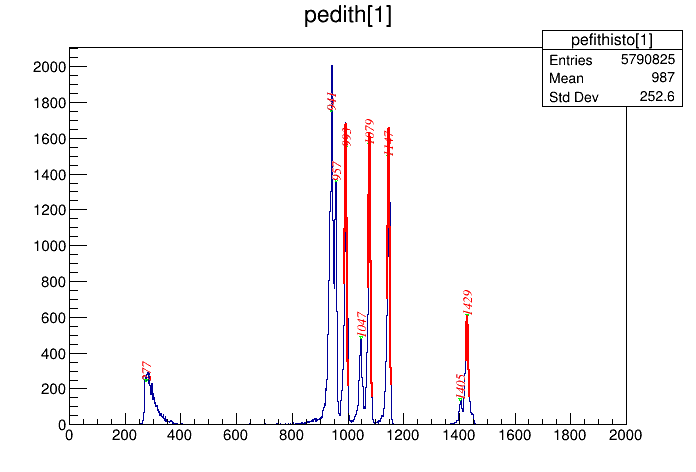

In [4]:
hfit1->Draw();
c1->Draw();

**刻度后结果**

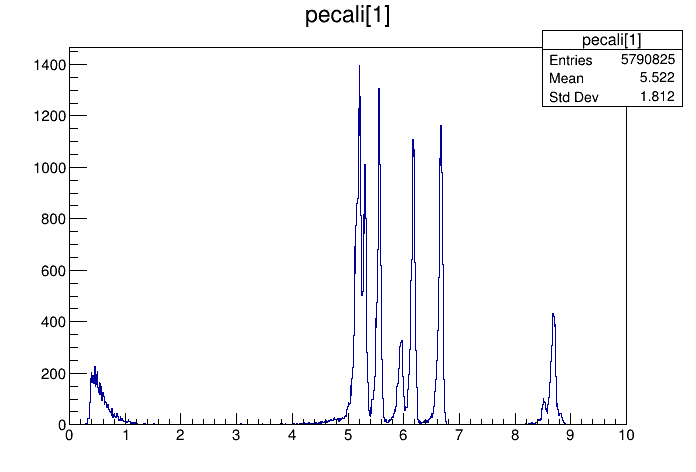

In [5]:
hcali1->Draw();
c1->Draw();

**偏差**

![avatar](./pediff[1].png)

**分辨 vs 条**

![avatar](./resolution.png)

**刻度前某条分辨 vs 刻度后所有条叠加**

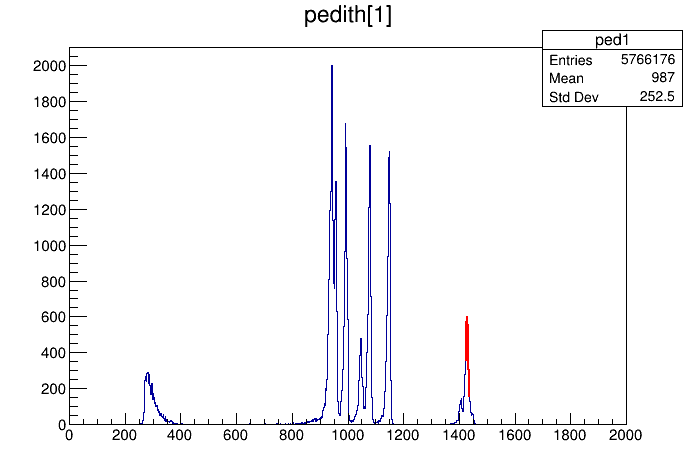

刻度前第一条分辨为：0.79%


In [6]:
tree->Draw("pedith[1]>>ped1(1000,0,2000)");
TH1D * ped1 = (TH1D*)gROOT->FindObject("ped1");
ped1->Fit("gaus","RQ+","",1424,1437);
ped1->Draw();
c1->Draw();

TF1 * f1 = ped1->GetFunction("gaus");
Double_t means1 = f1->GetParameter(1);
Double_t sigma1 = f1->GetParameter(2);
cout<<Form("刻度前第一条分辨为：%.2f", 2.355*sigma1/means1*100)<<"%"<<endl;

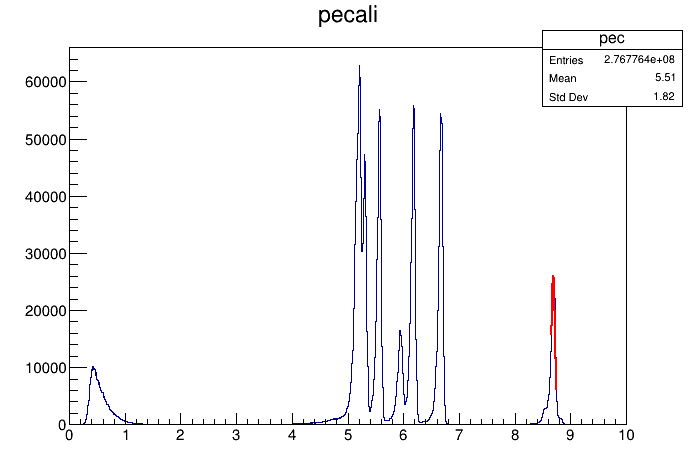

刻度后所有条叠加后分辨为：0.89%


In [7]:
tree->Draw("pecali>>pec(1000,0,10)");
TH1D * pec = (TH1D*)gROOT->FindObject("pec");
pec->Fit("gaus","RQ+","",8.66,8.75);
pec->Draw();
c1->Draw();

TF1 * f2 = pec->GetFunction("gaus");
Double_t means2 = f2->GetParameter(1);
Double_t sigma2 = f2->GetParameter(2);
cout<<Form("刻度后所有条叠加后分辨为：%.2f", 2.355*sigma2/means2*100)<<"%"<<endl;

In [8]:
!jupyter nbconvert homework3.1_2_cali.ipynb --to html

[NbConvertApp] Converting notebook homework3.1_2_cali.ipynb to html


